In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import cv2
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns
import albumentations as A

## Load DataFrame with Pathing

In [3]:
df = pd.read_csv('data/POC_imagedata.csv')

In [4]:
df.head()

,Country,Latitude,Longitude,Pano_Id,Path
0,Spain,36.477286,-5.880578,mnPCQWYwG-MIUV64ybl23g,data/images/Spain/0000/
1,Spain,37.600117,-4.341563,cXqaOBEMHANps9ZENoLozw,data/images/Spain/0001/
2,Spain,42.870488,-1.381516,RHuZZGXpb4levD1LK8Wtsw,data/images/Spain/0002/
3,Spain,41.296693,-3.603524,si-40KyaaKHFGdvy12nSIg,data/images/Spain/0003/
4,Spain,39.024927,-3.977601,wniI8AxaJ2gBC7q1GjV7GQ,data/images/Spain/0004/


In [5]:
#df = df.sample(1000)

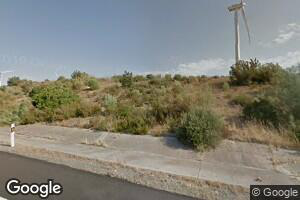

In [6]:
Image.open(df.Path.iloc[0] + 'N.jpg')

## Create Train / Validation Sets

In [7]:
train, val = train_test_split(df, test_size=0.20, stratify=df.Country.values)

In [8]:
train.shape

(2400, 5)

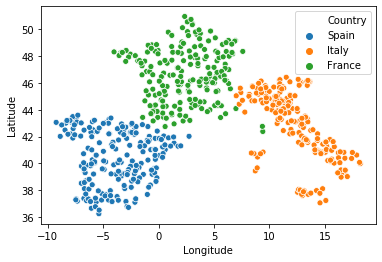

In [9]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='Country')

## Dataset

In [10]:
MAPPING = {'Spain': 0, # Spain
           'France': 1, # France
           'Italy': 2} # Italy

In [11]:
def img_to_np(fullpath):
    x = cv2.imread(fullpath).astype(np.uint8)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [12]:
def stitch_panos(path):
    return np.concatenate([img_to_np(path + direction + '.jpg') for direction in 'NESW'], axis=1)

In [13]:
def get_xy(path, y_map):
    x = stitch_panos(path)
    y = y_map[path[12: 12 + path[12:].find('/')]]
    return x, y

In [14]:
x, y = get_xy(train.Path.iloc[0], MAPPING)

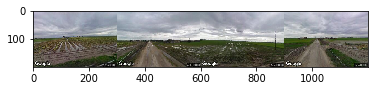

In [15]:
plt.imshow(x)

In [16]:
x.shape, y

((200, 1200, 3), 2)

#### Data Augmentation Functions

In [17]:
transforms = A.Compose([
        A.RandomCrop(height=150, width=900),
        A.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.15),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=22.5, p=0.25),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize()
    ])

no_transforms = A.Compose([
        A.CenterCrop(height=150, width=900),
        A.Normalize()
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(150, 900, 3)


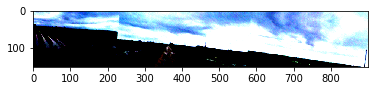

In [18]:
aug = transforms(image=x)['image']
print(aug.shape)
plt.imshow(aug)

(150, 900, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


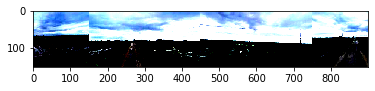

In [19]:
no_aug = no_transforms(image=x)['image']
print(no_aug.shape)
plt.imshow(no_aug)

In [20]:
class GeoDataset(Dataset):
    def __init__(self, df, transform=False):
        self.paths = [p for p in df.Path.values]
        self.transform = transform
        self.random_init()
        
    def random_init(self):
        self.random = np.random.rand(len(self.paths), 4)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        x, y = get_xy(self.paths[idx], MAPPING)
        
        if self.transform:
            x = transforms(image=x)['image']
        else:
            x = no_transforms(image=x)['image']
        
        x = np.rollaxis(x, 2)
        return x, y

In [21]:
train_ds = GeoDataset(train, transform=True)
valid_ds = GeoDataset(val)

In [22]:
x, y = train_ds[1]
x.shape, y

((3, 150, 900), 0)

## Model

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 128), nn.ReLU(), 
                                        nn.Dropout(), nn.Linear(128, 3))
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(self.dropout(x))
        return x

In [24]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        loss = F.cross_entropy(out, y, reduction='sum')
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [25]:
def train_epochs(model, train_dl, valid_dl, max_lr=0.001, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer2(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            lr = lrs[idx]
            update_optimizer2(optimizer, [lr/20, lr/10, lr])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y, reduction='sum')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch
            sum_loss += loss.item()
            idx += 1
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.75:
                path = "data/models/model_resnet18_stitch_loss_{0:.0f}.pth".format(100*val_acc)
                save_model(model, path)
                print(path)
    return path

In [26]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [27]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [28]:
def create_optimizer2(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/50},
              {'params': model.features2.parameters(), 'lr': lr0/20},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=2e-5)

def update_optimizer2(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [29]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [30]:
model = Net().cuda()

In [31]:
val_metrics(model, valid_dl)

(1.1225798479715983, 0.3333333333333333)

In [32]:
best_path = train_epochs(model, train_dl, valid_dl, max_lr=0.0008, epochs=30)

train_loss 1.125 val_loss 1.077 val_acc 0.422
train_loss 1.102 val_loss 1.038 val_acc 0.520
train_loss 1.059 val_loss 0.963 val_acc 0.575
train_loss 0.986 val_loss 0.867 val_acc 0.622
train_loss 0.911 val_loss 0.790 val_acc 0.662
train_loss 0.836 val_loss 0.749 val_acc 0.680
train_loss 0.771 val_loss 0.728 val_acc 0.710
train_loss 0.724 val_loss 0.697 val_acc 0.723
train_loss 0.666 val_loss 0.700 val_acc 0.712
train_loss 0.611 val_loss 0.674 val_acc 0.722
train_loss 0.549 val_loss 0.855 val_acc 0.675
train_loss 0.558 val_loss 0.615 val_acc 0.745
train_loss 0.480 val_loss 0.692 val_acc 0.742
train_loss 0.429 val_loss 0.660 val_acc 0.750
train_loss 0.406 val_loss 0.848 val_acc 0.737
train_loss 0.346 val_loss 0.813 val_acc 0.733
train_loss 0.351 val_loss 0.757 val_acc 0.750
train_loss 0.358 val_loss 0.679 val_acc 0.758
data/models/model_resnet18_stitch_loss_76.pth
train_loss 0.288 val_loss 0.705 val_acc 0.755
train_loss 0.251 val_loss 0.649 val_acc 0.772
data/models/model_resnet18_stitch_

In [33]:
#data/models/model_resnet18_stitch_loss_78.pth

## Prediction Evaluation

In [34]:
best_model = Net().cuda()
load_model(best_model, best_path)

In [35]:
val.head()

,Country,Latitude,Longitude,Pano_Id,Path
348,Spain,43.107342,-5.979951,hLzP6AUvZC_7NdM9SuvvrA,data/images/Spain/0348/
868,Spain,37.676211,-4.779873,KZBlfSaWG7mMvI_VjD8Kqg,data/images/Spain/0868/
798,Spain,42.642506,-3.287322,Hl00GAtH2Uw-Ua0Wp1O_Qw,data/images/Spain/0798/
2947,Italy,42.980776,10.689066,dW73DwB9WAgFzQezApanzQ,data/images/Italy/0947/
1276,France,47.654026,5.263215,-c8L9foCYsTyAZxHh0mY9w,data/images/France/0276/


In [36]:
rev_map = {v: k for k,v in MAPPING.items()}
rev_map

{0: 'Spain', 1: 'France', 2: 'Italy'}

In [37]:
preds = []
with torch.no_grad():
    best_model.eval()
    for x, y in valid_dl:
        out = best_model(x.cuda().float())
        _, pred = torch.max(out, 1)
        pred = pred.cpu().detach().numpy()
        preds += [rev_map[p] for p in pred]

In [38]:
val['predictions'] = preds

In [39]:
val.head()

,Country,Latitude,Longitude,Pano_Id,Path,predictions
348,Spain,43.107342,-5.979951,hLzP6AUvZC_7NdM9SuvvrA,data/images/Spain/0348/,France
868,Spain,37.676211,-4.779873,KZBlfSaWG7mMvI_VjD8Kqg,data/images/Spain/0868/,Spain
798,Spain,42.642506,-3.287322,Hl00GAtH2Uw-Ua0Wp1O_Qw,data/images/Spain/0798/,Italy
2947,Italy,42.980776,10.689066,dW73DwB9WAgFzQezApanzQ,data/images/Italy/0947/,Italy
1276,France,47.654026,5.263215,-c8L9foCYsTyAZxHh0mY9w,data/images/France/0276/,France


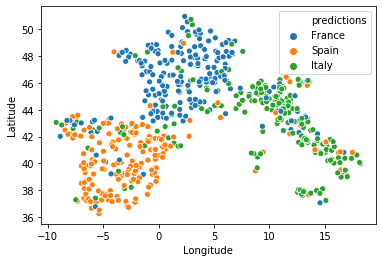

In [40]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='predictions')

In [41]:
(val.Country == val.predictions).sum() / len(val)

0.7816666666666666